In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_025_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_025_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.8895 - acc: 0.2294
Epoch 00001: val_loss improved from inf to 2.48995, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_1_conv_checkpoint/001-2.4899.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 3.8891 - acc: 0.2295 - val_loss: 2.4899 - val_acc: 0.2057
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5710 - acc: 0.5419
Epoch 00002: val_loss did not improve from 2.48995
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.5710 - acc: 0.5419 - val_loss: 2.6835 - val_acc: 0.2756
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0821 - acc: 0.9844
Epoch 00027: val_loss did not improve from 2.48995
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0821 - acc: 0.9844 - val_loss: 7.0044 - val_acc: 0.2602
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0772 - acc: 0.9874
Epoch 00028: val_loss did not improve from 2.48995
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0772 - acc: 0.9874 - val_loss: 6.5126 - val_acc: 0.2835
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9894
Epoch 00029: val_loss did not improve from 2.48995
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0707 - acc: 0.9894 - val_loss: 7.1590 - val_acc: 0.2648
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9886
Epoch 00030: val_loss did not improve from 2.48995
36805/36805 [===========

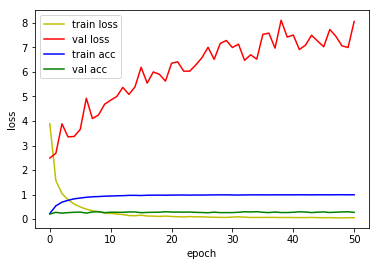

4815/4815 [==============================] - 2s 406us/sample - loss: 2.5254 - acc: 0.2069
Loss: 2.5254280345338405 Accuracy: 0.20685358

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.9660 - acc: 0.2614
Epoch 00001: val_loss improved from inf to 4.33879, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_2_conv_checkpoint/001-4.3388.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 4.9660 - acc: 0.2614 - val_loss: 4.3388 - val_acc: 0.2863
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.9934 - acc: 0.4211
Epoch 00002: val_loss did not improve from 4.33879
36805/36805 [==============================] - 71s 2ms/sample - loss: 3.9936 - acc: 0.4210 - val_loss: 4.4165 - val_acc: 0.3007
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6382 - acc: 0.5160
Epoch 00003: val_loss did not improve from 4.33879
36805/36805 [=========

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6005 - acc: 0.8246
Epoch 00030: val_loss did not improve from 4.33879
36805/36805 [==============================] - 70s 2ms/sample - loss: 2.6010 - acc: 0.8246 - val_loss: 6.8246 - val_acc: 0.3673
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5981 - acc: 0.8257
Epoch 00031: val_loss did not improve from 4.33879
36805/36805 [==============================] - 70s 2ms/sample - loss: 2.5978 - acc: 0.8257 - val_loss: 6.4996 - val_acc: 0.3802
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6048 - acc: 0.8241
Epoch 00032: val_loss did not improve from 4.33879
36805/36805 [==============================] - 71s 2ms/sample - loss: 2.6045 - acc: 0.8241 - val_loss: 7.3339 - val_acc: 0.3275
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6091 - acc: 0.8228
Epoch 00033: val_loss did not improve from 4.33879
36805/36805 [===========

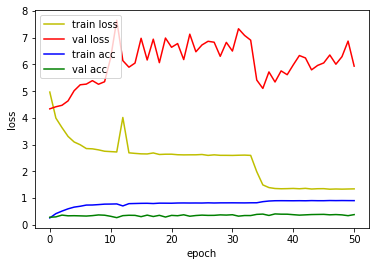

4815/4815 [==============================] - 3s 698us/sample - loss: 4.4010 - acc: 0.2760
Loss: 4.401042298488281 Accuracy: 0.27601245

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1249 - acc: 0.3720
Epoch 00001: val_loss improved from inf to 1.74177, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_3_conv_checkpoint/001-1.7418.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.1248 - acc: 0.3720 - val_loss: 1.7418 - val_acc: 0.4470
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3948 - acc: 0.5676
Epoch 00002: val_loss did not improve from 1.74177
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.3947 - acc: 0.5676 - val_loss: 1.7816 - val_acc: 0.4698
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0684 - acc: 0.6674
Epoch 00003: val_loss improved from 1.74177 to 1.55105, saving model to mo

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9811
Epoch 00029: val_loss did not improve from 1.51802
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0682 - acc: 0.9811 - val_loss: 2.8234 - val_acc: 0.5665
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0745 - acc: 0.9789
Epoch 00030: val_loss did not improve from 1.51802
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0745 - acc: 0.9789 - val_loss: 2.2936 - val_acc: 0.6201
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9876
Epoch 00031: val_loss did not improve from 1.51802
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0471 - acc: 0.9875 - val_loss: 2.7262 - val_acc: 0.5882
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0689 - acc: 0.9804
Epoch 00032: val_loss did not improve from 1.51802
36805/36805 [===========

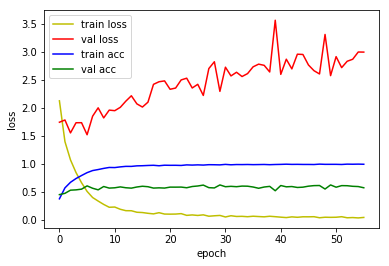

4815/4815 [==============================] - 4s 814us/sample - loss: 1.6474 - acc: 0.5639
Loss: 1.647401433520847 Accuracy: 0.5638629

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9213 - acc: 0.4033
Epoch 00001: val_loss improved from inf to 1.63404, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_4_conv_checkpoint/001-1.6340.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.9212 - acc: 0.4033 - val_loss: 1.6340 - val_acc: 0.4498
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2639 - acc: 0.6059
Epoch 00002: val_loss improved from 1.63404 to 1.14084, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_4_conv_checkpoint/002-1.1408.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.2639 - acc: 0.6059 - val_loss: 1.1408 - val_acc: 0.6464
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9724
Epoch 00028: val_loss did not improve from 1.02818
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0975 - acc: 0.9724 - val_loss: 1.2868 - val_acc: 0.7191
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9745
Epoch 00029: val_loss did not improve from 1.02818
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0930 - acc: 0.9745 - val_loss: 1.4682 - val_acc: 0.6860
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0950 - acc: 0.9736
Epoch 00030: val_loss did not improve from 1.02818
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0950 - acc: 0.9736 - val_loss: 1.2691 - val_acc: 0.7244
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0886 - acc: 0.9753
Epoch 00031: val_loss did not improve from 1.02818
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9871
Epoch 00058: val_loss did not improve from 1.02818
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0498 - acc: 0.9871 - val_loss: 1.4267 - val_acc: 0.7365
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9856
Epoch 00059: val_loss did not improve from 1.02818
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0500 - acc: 0.9856 - val_loss: 1.6090 - val_acc: 0.7093
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9906
Epoch 00060: val_loss did not improve from 1.02818
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0381 - acc: 0.9906 - val_loss: 1.5021 - val_acc: 0.7244

1D_CNN_custom_DO_025_DO_BN_4_conv Model


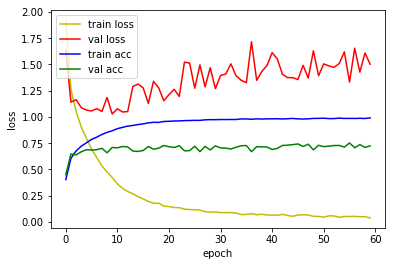

4815/4815 [==============================] - 4s 848us/sample - loss: 1.1698 - acc: 0.6625
Loss: 1.1697958334955472 Accuracy: 0.66251296

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8453 - acc: 0.4267
Epoch 00001: val_loss improved from inf to 1.63311, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_5_conv_checkpoint/001-1.6331.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.8454 - acc: 0.4266 - val_loss: 1.6331 - val_acc: 0.4687
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1754 - acc: 0.6339
Epoch 00002: val_loss improved from 1.63311 to 1.00287, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_5_conv_checkpoint/002-1.0029.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.1753 - acc: 0.6340 - val_loss: 1.0029 - val_acc: 0.6830
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.1201 - acc: 0.9658
Epoch 00027: val_loss did not improve from 0.78493
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1203 - acc: 0.9657 - val_loss: 1.0088 - val_acc: 0.7629
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1309 - acc: 0.9619
Epoch 00028: val_loss did not improve from 0.78493
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1309 - acc: 0.9619 - val_loss: 0.9481 - val_acc: 0.7773
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1049 - acc: 0.9695
Epoch 00029: val_loss did not improve from 0.78493
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1049 - acc: 0.9695 - val_loss: 1.0633 - val_acc: 0.7615
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9728
Epoch 00030: val_loss did not improve from 0.78493
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9846
Epoch 00057: val_loss did not improve from 0.78493
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0539 - acc: 0.9846 - val_loss: 0.9011 - val_acc: 0.8195
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9864
Epoch 00058: val_loss did not improve from 0.78493
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0491 - acc: 0.9864 - val_loss: 1.1056 - val_acc: 0.7901
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9878
Epoch 00059: val_loss did not improve from 0.78493
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0440 - acc: 0.9878 - val_loss: 1.1220 - val_acc: 0.7827
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0600 - acc: 0.9827
Epoch 00060: val_loss did not improve from 0.78493
36805/36805 [===========

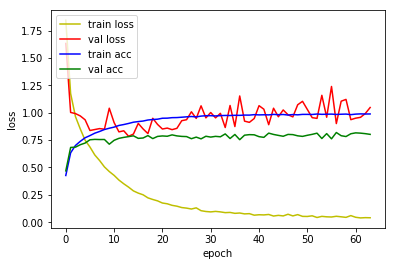

4815/4815 [==============================] - 5s 942us/sample - loss: 0.8147 - acc: 0.7653
Loss: 0.8146993243558137 Accuracy: 0.7653167

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8375 - acc: 0.4249
Epoch 00001: val_loss improved from inf to 1.38638, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_6_conv_checkpoint/001-1.3864.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.8375 - acc: 0.4249 - val_loss: 1.3864 - val_acc: 0.5572
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1315 - acc: 0.6462
Epoch 00002: val_loss improved from 1.38638 to 0.89790, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_6_conv_checkpoint/002-0.8979.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.1315 - acc: 0.6462 - val_loss: 0.8979 - val_acc: 0.7368
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1761 - acc: 0.9475
Epoch 00026: val_loss did not improve from 0.43800
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1760 - acc: 0.9475 - val_loss: 0.5198 - val_acc: 0.8717
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1549 - acc: 0.9549
Epoch 00027: val_loss did not improve from 0.43800
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1549 - acc: 0.9549 - val_loss: 0.4494 - val_acc: 0.8880
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9566
Epoch 00028: val_loss did not improve from 0.43800
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1490 - acc: 0.9566 - val_loss: 0.4689 - val_acc: 0.8721
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1444 - acc: 0.9579
Epoch 00029: val_loss did not improve from 0.43800
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9820
Epoch 00055: val_loss did not improve from 0.43659
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0640 - acc: 0.9820 - val_loss: 0.5234 - val_acc: 0.8831
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9850
Epoch 00056: val_loss did not improve from 0.43659
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0533 - acc: 0.9850 - val_loss: 0.5623 - val_acc: 0.8761
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9861
Epoch 00057: val_loss did not improve from 0.43659
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0503 - acc: 0.9861 - val_loss: 0.4462 - val_acc: 0.8991
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9853
Epoch 00058: val_loss did not improve from 0.43659
36805/36805 [========================

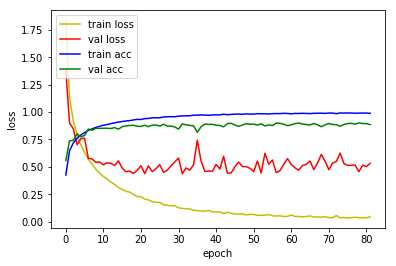

4815/4815 [==============================] - 5s 955us/sample - loss: 0.5152 - acc: 0.8633
Loss: 0.51524708325494 Accuracy: 0.8633437

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8948 - acc: 0.4029
Epoch 00001: val_loss improved from inf to 1.35416, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_7_conv_checkpoint/001-1.3542.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 1.8948 - acc: 0.4029 - val_loss: 1.3542 - val_acc: 0.5823
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0738 - acc: 0.6629
Epoch 00002: val_loss improved from 1.35416 to 0.79796, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_7_conv_checkpoint/002-0.7980.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.0738 - acc: 0.6629 - val_loss: 0.7980 - val_acc: 0.7626
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9679
Epoch 00025: val_loss did not improve from 0.25202
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1075 - acc: 0.9679 - val_loss: 0.2727 - val_acc: 0.9276
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1078 - acc: 0.9681
Epoch 00026: val_loss did not improve from 0.25202
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1078 - acc: 0.9681 - val_loss: 0.2820 - val_acc: 0.9229
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9713
Epoch 00027: val_loss did not improve from 0.25202
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0960 - acc: 0.9713 - val_loss: 0.3099 - val_acc: 0.9131
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9688
Epoch 00028: val_loss did not improve from 0.25202
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9884
Epoch 00054: val_loss did not improve from 0.22326
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0388 - acc: 0.9884 - val_loss: 0.3138 - val_acc: 0.9243
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9920
Epoch 00055: val_loss did not improve from 0.22326
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0301 - acc: 0.9920 - val_loss: 0.2820 - val_acc: 0.9359
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9901
Epoch 00056: val_loss did not improve from 0.22326
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0337 - acc: 0.9901 - val_loss: 0.3121 - val_acc: 0.9322
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9913
Epoch 00057: val_loss did not improve from 0.22326
36805/36805 [===========

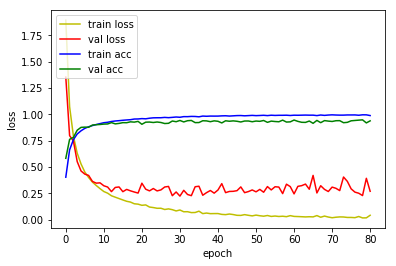

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2617 - acc: 0.9269
Loss: 0.2617387284278127 Accuracy: 0.92689514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7937 - acc: 0.4441
Epoch 00001: val_loss improved from inf to 1.32118, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_8_conv_checkpoint/001-1.3212.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.7938 - acc: 0.4440 - val_loss: 1.3212 - val_acc: 0.5924
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8840 - acc: 0.7310
Epoch 00002: val_loss improved from 1.32118 to 0.58305, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_8_conv_checkpoint/002-0.5830.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.8840 - acc: 0.7310 - val_loss: 0.5830 - val_acc: 0.8376
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9848
Epoch 00026: val_loss did not improve from 0.15546
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0534 - acc: 0.9848 - val_loss: 0.2046 - val_acc: 0.9418
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0588 - acc: 0.9826
Epoch 00027: val_loss did not improve from 0.15546
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0588 - acc: 0.9826 - val_loss: 0.1759 - val_acc: 0.9532
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9852
Epoch 00028: val_loss did not improve from 0.15546
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0524 - acc: 0.9852 - val_loss: 0.2117 - val_acc: 0.9422
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9823
Epoch 00029: val_loss did not improve from 0.15546
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9962
Epoch 00055: val_loss did not improve from 0.14848
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0139 - acc: 0.9962 - val_loss: 0.1801 - val_acc: 0.9557
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9948
Epoch 00056: val_loss did not improve from 0.14848
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0198 - acc: 0.9948 - val_loss: 0.1658 - val_acc: 0.9618
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9956
Epoch 00057: val_loss did not improve from 0.14848
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0167 - acc: 0.9956 - val_loss: 0.1669 - val_acc: 0.9606
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9942
Epoch 00058: val_loss did not improve from 0.14848
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9985
Epoch 00084: val_loss did not improve from 0.13935
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0058 - acc: 0.9985 - val_loss: 0.2106 - val_acc: 0.9555
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9968
Epoch 00085: val_loss did not improve from 0.13935
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0111 - acc: 0.9968 - val_loss: 0.2640 - val_acc: 0.9406
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9918
Epoch 00086: val_loss did not improve from 0.13935
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0270 - acc: 0.9918 - val_loss: 0.1701 - val_acc: 0.9630
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9980
Epoch 00087: val_loss did not improve from 0.13935
36805/36805 [========================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9972
Epoch 00114: val_loss did not improve from 0.13935
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0100 - acc: 0.9972 - val_loss: 0.1964 - val_acc: 0.9585
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9967
Epoch 00115: val_loss did not improve from 0.13935
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0110 - acc: 0.9967 - val_loss: 0.2215 - val_acc: 0.9529
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9982
Epoch 00116: val_loss did not improve from 0.13935
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0070 - acc: 0.9982 - val_loss: 0.1835 - val_acc: 0.9625
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9977
Epoch 00117: val_loss did not improve from 0.13935
36805/36805 [=======

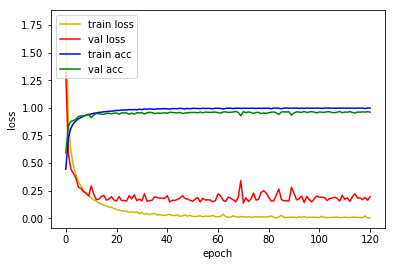

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2110 - acc: 0.9512
Loss: 0.2109833645048287 Accuracy: 0.95119417

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3765 - acc: 0.5711
Epoch 00001: val_loss improved from inf to 0.75864, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_9_conv_checkpoint/001-0.7586.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.3763 - acc: 0.5712 - val_loss: 0.7586 - val_acc: 0.7941
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5542 - acc: 0.8296
Epoch 00002: val_loss improved from 0.75864 to 0.41967, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_9_conv_checkpoint/002-0.4197.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.5542 - acc: 0.8296 - val_loss: 0.4197 - val_acc: 0.8747
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9898
Epoch 00026: val_loss did not improve from 0.14210
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0337 - acc: 0.9898 - val_loss: 0.1641 - val_acc: 0.9546
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9896
Epoch 00027: val_loss did not improve from 0.14210
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0359 - acc: 0.9896 - val_loss: 0.1592 - val_acc: 0.9567
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9942
Epoch 00028: val_loss improved from 0.14210 to 0.13774, saving model to model/checkpoint/1D_CNN_custom_DO_025_DO_BN_9_conv_checkpoint/028-0.1377.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0222 - acc: 0.9942 - val_loss: 0.1377 - val_acc: 0.9623
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9958
Epoch 00055: val_loss did not improve from 0.13463
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0135 - acc: 0.9958 - val_loss: 0.1733 - val_acc: 0.9576
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9973
Epoch 00056: val_loss did not improve from 0.13463
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0097 - acc: 0.9973 - val_loss: 0.1539 - val_acc: 0.9651
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9968
Epoch 00057: val_loss did not improve from 0.13463
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0103 - acc: 0.9968 - val_loss: 0.1512 - val_acc: 0.9672
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9949
Epoch 00058: val_loss did not improve from 0.13463
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9988
Epoch 00084: val_loss did not improve from 0.13428
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0040 - acc: 0.9988 - val_loss: 0.1499 - val_acc: 0.9693
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9981
Epoch 00085: val_loss did not improve from 0.13428
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0062 - acc: 0.9981 - val_loss: 0.1783 - val_acc: 0.9611
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9978
Epoch 00086: val_loss did not improve from 0.13428
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0075 - acc: 0.9978 - val_loss: 0.1896 - val_acc: 0.9611
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9987
Epoch 00087: val_loss did not improve from 0.13428
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9998
Epoch 00113: val_loss did not improve from 0.13414
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0015 - acc: 0.9998 - val_loss: 0.1542 - val_acc: 0.9681
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9981
Epoch 00114: val_loss did not improve from 0.13414
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0061 - acc: 0.9981 - val_loss: 0.2370 - val_acc: 0.9578
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9985
Epoch 00115: val_loss did not improve from 0.13414
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0057 - acc: 0.9984 - val_loss: 0.1810 - val_acc: 0.9648
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9963
Epoch 00116: val_loss did not improve from 0.13414
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9995
Epoch 00142: val_loss did not improve from 0.13345
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0021 - acc: 0.9995 - val_loss: 0.1700 - val_acc: 0.9667
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9986
Epoch 00143: val_loss did not improve from 0.13345
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0045 - acc: 0.9986 - val_loss: 0.1571 - val_acc: 0.9693
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9996
Epoch 00144: val_loss did not improve from 0.13345
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0018 - acc: 0.9996 - val_loss: 0.1675 - val_acc: 0.9667
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9981
Epoch 00145: val_loss did not improve from 0.13345
36805/36805 [=====================

Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9996
Epoch 00172: val_loss did not improve from 0.13345
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0016 - acc: 0.9996 - val_loss: 0.1467 - val_acc: 0.9716
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.9735e-04 - acc: 0.9997
Epoch 00173: val_loss did not improve from 0.13345
36805/36805 [==============================] - 92s 2ms/sample - loss: 9.9722e-04 - acc: 0.9997 - val_loss: 0.1672 - val_acc: 0.9681
Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9993
Epoch 00174: val_loss did not improve from 0.13345
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0021 - acc: 0.9993 - val_loss: 0.1928 - val_acc: 0.9627

1D_CNN_custom_DO_025_DO_BN_9_conv Model


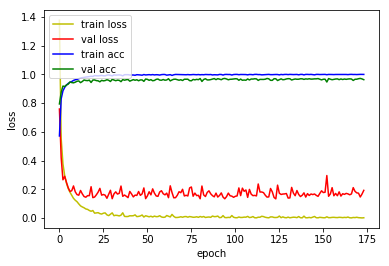

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2022 - acc: 0.9578
Loss: 0.20217632674878797 Accuracy: 0.9578401



In [9]:
for i in range(1, 10):
    base = '1D_CNN_custom_DO_025_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_025_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_025_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.1698 - acc: 0.6625
Loss: 1.1697958334955472 Accuracy: 0.66251296

1D_CNN_custom_DO_025_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (Non

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2617 - acc: 0.9269
Loss: 0.2617387284278127 Accuracy: 0.92689514

1D_CNN_custom_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (Non

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2022 - acc: 0.9578
Loss: 0.20217632674878797 Accuracy: 0.9578401


In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.6612 - acc: 0.6974
Loss: 1.661245329679606 Accuracy: 0.69740397

1D_CNN_custom_DO_025_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.3175 - acc: 0.9263
Loss: 0.3175306691984459 Accuracy: 0.9262721

1D_CNN_custom_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2460 - acc: 0.9524
Loss: 0.24604999006145267 Accuracy: 0.95244026
